In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import sys

from normalizingflows.flow_catalog import PlanarFlow
from data.visu_density import plot_heatmap_2d
from data.toy_data import generate_2d_data
from data.plot_samples import plot_samples_2d
from utils.train_utils import shuffle_split, sanity_check, train_density_estimation

tfd = tfp.distributions
tfb = tfp.bijectors
tf.random.set_seed(1234)

tensorflow:  2.0.0
tensorflow-probability:  0.8.0-rc0


In [2]:
# parameters
dataset_size = 2000
batch_size = 800
dataset = 'checkerboard'
layers = 8
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(15e3)

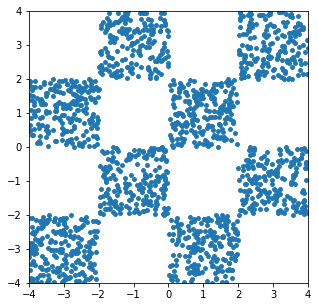

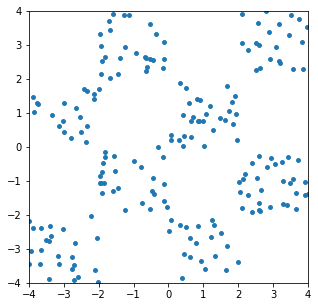

In [3]:
train_split = 0.8
val_split = 0.1
samples, _ = generate_2d_data(dataset, batch_size=dataset_size)
train_data, val_data, test_data = shuffle_split(samples, train_split, val_split)
plot_samples_2d(train_data)
plot_samples_2d(val_data)

train_data = tf.data.Dataset.from_tensor_slices(train_data)
batched_train_data = train_data.batch(batch_size)

In [5]:
# assign a normal distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))

In [6]:
# create a flow
bijectors = []

for i in range(0, layers):
    bijectors.append(PlanarFlow(input_dimensions=2, case="density_estimation"))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')

x_dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)

In [7]:
# ensure invertibility
for bijector in x_dist.bijector.bijectors:
    bijector._u()
print(len(x_dist.trainable_variables))

24


In [8]:
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

In [9]:
checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

In [ ]:
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(x_dist, opt, batch)

    # ensure that w.T * u > -1 (invertibility)
    for bijector in x_dist.bijector.bijectors:
        bijector._u()

    if i % int(100) == 0:
        val_loss = -tf.reduce_mean(x_dist.log_prob(val_data))
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

    if i % int(1000) == 0:
        # plot heatmap
        plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0)

train_time = time.time() - t_start

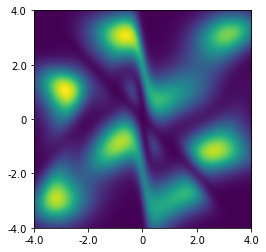

In [11]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()
test_loss = -tf.reduce_mean(x_dist.log_prob(test_data))
test_time = time.time() - t_start

# save density estimation of best model
save_dir = dataset + "/" + dataset + "_density_" + str(batch_size) + "_" + str(layers) + "_" + str(base_lr) + "_" + str(min_val_epoch)
plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0, name=save_dir)

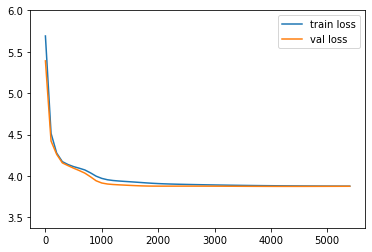

In [12]:
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.ylim((min_val_loss-0.5).numpy(), 6)
plt.legend()

In [13]:
# Sanity check: ensure that the integral of the pdf sums up to 1
# create 2D mesh grid with N samples
integral = sanity_check(x_dist, xmin=-6.0, xmax=6.0, ymin=-6.0, ymax=6.0, mesh_count=2000)
print(integral)

tf.Tensor(0.9989626, shape=(), dtype=float32)
